In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi
!pip install -U git+https://github.com/qubvel/efficientnet

Fri Jun 12 12:20:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 載入套件

In [0]:
%tensorflow_version 2.x

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow.keras.callbacks as cb
import tensorflow.keras.layers as L
import tensorflow.keras as K
import tensorflow as tf
import tensorflow_addons as tfa

import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import os, zipfile, cv2

# tf.keras.backend.set_learning_phase(True)

# 載入資料
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 12
NUM_EPOCHS = 40
STEPS = 128
NUM_CLASSES = 3
DATASET_PATH = '/content/datasets-300-ownsplit/'

In [0]:
if not os.path.exists('datasets-300-ownsplit'):
    f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/datasets-300-ownsplit.zip")
    f.extractall("./")

In [15]:
len(glob(DATASET_PATH + '*/*/*'))

1105

# 模型建立

In [7]:
net = efn.EfficientNetB7(input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3),
                         weights= 'noisy-student',
                         include_top= False)

for layer in net.layers:
    layer.trainable = True

x = net.output
# BN-Relu
x = L.BatchNormalization()(x)
x = L.Activation('relu')(x)
x = L.GlobalMaxPooling2D()(x)
out = L.Dense(NUM_CLASSES, 
              activation='softmax')(x)

model = Model(inputs=net.input, outputs=out)

258072576/258068648 [==============================] - 6s 0us/step


In [0]:
# model.summary()

# plot_model(model, to_file='conv_base.png', show_shapes=True)

# 模型編譯

In [0]:
import tensorflow.keras as K

model.compile(loss= K.losses.CategoricalCrossentropy(), 
              optimizer= K.optimizers.Adam(), 
              metrics= [K.metrics.CategoricalAccuracy()])

# 建立  Learning rate

In [0]:
def lrfn(epoch):
    LR_START = 0.0001
    LR_MAX = 0.00005
    LR_MIN = 0.0001
    LR_RAMPUP_EPOCHS = 4
    LR_SUSTAIN_EPOCHS = 6
    LR_EXP_DECAY = .8

    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = cb.LearningRateScheduler(lrfn, verbose=True)

rl_callback = cb.ReduceLROnPlateau(monitor = "val_loss", 
                                   factor = 0.5, 
                                   patience = 5, 
                                   min_lr = 1e-6)

es_callback = cb.EarlyStopping(patience=15, restore_best_weights=True)

mc_callback = cb.ModelCheckpoint(os.path.join('/content/drive/My Drive', 'model_siamese.h5'), 
                                 save_best_only=True, 
                                 save_weights_only=False)

# rng = [i for i in range(NUM_EPOCHS)]
# y = [lrfn(x) for x in rng]
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

callbacks = [lr_callback,
             rl_callback,
            #  es_callback,
            #  mc_callback,
             ]

# 設定  data augmentation

In [23]:
trn_dagen = ImageDataGenerator(rescale= 1. / 255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               channel_shift_range=10,
                               horizontal_flip=True,
                               fill_mode='nearest')

trn_gen = trn_dagen.flow_from_directory(DATASET_PATH + 'train',
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True)



eva_dagen = ImageDataGenerator(rescale= 1./ 255,
                               validation_split=0.5)

val_gen = eva_dagen.flow_from_directory(DATASET_PATH + 'test',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE,
                                            class_mode='categorical',
                                            subset='training',
                                            shuffle=True)
eva_gen = eva_dagen.flow_from_directory(DATASET_PATH + 'test',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE * 3,
                                            class_mode='categorical',
                                            subset='validation',
                                            shuffle=True)

Found 664 images belonging to 3 classes.
Found 221 images belonging to 3 classes.
Found 220 images belonging to 3 classes.


# 模型訓練

In [24]:
STEP_SIZE_TRAIN = trn_gen.n // BATCH_SIZE
STEP_SIZE_VALID = val_gen.n // BATCH_SIZE

history = model.fit(trn_gen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= NUM_EPOCHS,
                    verbose= 1,
                    validation_data= val_gen,
                    validation_steps= STEP_SIZE_VALID,
                    callbacks= callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/40
55/55 [==============================] - 37s 671ms/step - loss: 2.7968 - categorical_accuracy: 0.3374 - val_loss: 1.0835 - val_categorical_accuracy: 0.5046 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 8.75e-05.
Epoch 2/40
55/55 [==============================] - 32s 587ms/step - loss: 1.7410 - categorical_accuracy: 0.4540 - val_loss: 0.9305 - val_categorical_accuracy: 0.6296 - lr: 8.7500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 7.500000000000001e-05.
Epoch 3/40
55/55 [==============================] - 32s 580ms/step - loss: 1.2801 - categorical_accuracy: 0.6058 - val_loss: 0.7476 - val_categorical_accuracy: 0.7361 - lr: 7.5000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 4/40
55/55 [==============================] - 32s 579ms/step - loss: 1.3432 - categorical_accuracy: 0.5905 - val_loss: 0.7091 - val_categorical

# 評估模型

In [25]:
loss, acc = model.evaluate(eva_gen, steps= 64)
print('評估的準確率::  ', acc)

 7/64 [==>...........................] - 3s 453ms/step - loss: 0.3952 - categorical_accuracy: 0.8955
評估的準確率::   0.8954545259475708


Text(0.5, 1.0, 'acc')

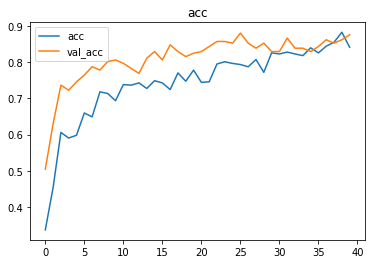

In [26]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

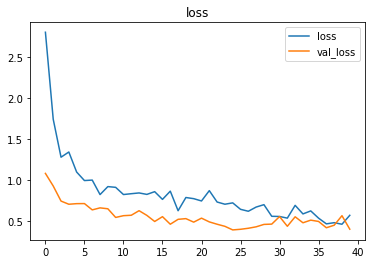

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

## 混淆矩陣觀察預測結果

In [28]:
import pandas as pd
from sklearn.metrics import confusion_matrix

train, label = eva_gen.next()

pre = model.predict(train, steps= 1)
pre = pre.argmax(axis= -1)
label = label.argmax(axis= -1)

df = pd.DataFrame(confusion_matrix(label, pre))
df

,0,1,2
0,12,0,0
1,1,7,0
2,0,2,14
